In [13]:
from datetime import datetime
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import ppigrf

DEBUG = None # to be set later

In [14]:
## Some constants

M = 5 # nuclear mass unit u
# 1 u = 1.66e-27 kg

CHARGE = 2 # charge of the nucleus in units of the elementary charge
# 1 e = 1.6e-19 C

SPEED_OF_LIGHT = 3e8 # m/s

DATE = datetime(2021, 3, 28)

## Conversion factor when computing the Lorentz force
# F = gamma * q * v x B
CONVERSION_FACTOR = 1.66e27 * 1.6e-19 * 1e-9
# where we also converted from nT to T
R_EARTH = 6.4e6 # m


### Modelling the magnetic field
- as a sanity check we can use a simple homogeneous magnetic field in the z direction
$$
\mathbf{B} = B_0 \mathbf{e}_z
$$
- In the simplest approximation, the magnetic field can be modelled as a dipole field. In cartesian coordinates, it is given by:
$$
\mathbf{B} = ...
$$ 
TODO: check
TODO: check reference
- A far better approximation is given by the IGRF model. The IGRF model is given by a sum of spherical harmonics. The coefficients are fitted to measurements and account for time variations.

In [15]:
## helpers for IGRF, since it is given in spherical coordinates
def cartesian_to_spherical(v: np.ndarray) -> np.ndarray:
    return np.array([
        np.linalg.norm(v),
        np.degrees(np.arctan2(np.linalg.norm(v[:2]), v[2])),
        np.degrees(np.arctan2(v[1], v[0]))
    ])


#I'm lazy, so I redefine
cosd = lambda x: np.cos(np.deg2rad(x))
sind = lambda x: np.sin(np.deg2rad(x))
def B_to_cartesian(r_vec: np.ndarray, B: np.ndarray) -> np.ndarray:
    # express the spherical components of B in cartesian coordinates through the jacobian
    # (Bx, By, Bz) = J * (Br, Btheta, Bphi)
    # JACOBIAN = np.array([
    #     [np.sin(np.radians(r[1])) * np.cos(np.radians(r[2])), np.cos(np.radians(r[1])) * np.cos(np.radians(r[2])), -np.sin(np.radians(r[1])) * np.sin(np.radians(r[2]))],
    #     [np.sin(np.radians(r[1])) * np.sin(np.radians(r[2])), np.cos(np.radians(r[1])) * np.sin(np.radians(r[2])), np.sin(np.radians(r[1])) * np.cos(np.radians(r[2]))],
    #     [np.cos(np.radians(r[1])), -np.sin(np.radians(r[1])), 0]
    # ])
    r = r_vec[0] # though not needed
    theta = r_vec[1]
    phi = r_vec[2]
    JACOBIAN = np.array([
        [cosd(theta) * cosd(phi), - sind(theta) * cosd(phi), -cosd(theta) * sind(phi)],
        [cosd(theta) * sind(phi), sind(theta) * sind(phi), cosd(theta) * cosd(phi)],
        [sind(theta), cosd(theta), sind(theta)]
    ])
    B_cart = JACOBIAN @ B
    if DEBUG:
        print(f"spherical B = {np.linalg.norm(B)}, cartesian B = {np.linalg.norm(B_cart)}")
    return B_cart


B_INTENSITY = 1e4 # nT # to be on par with the measured values
## Different implementations of the magnetic field
def simple_field(x):
    B = np.array([0, 0, 1]) * B_INTENSITY
    return B


def dipole_field(x):
    intensity = B_INTENSITY * 1e-2
    r = np.linalg.norm(x)
    B =  intensity * R_EARTH**3 / r**5 * np.array([
        3 * x[2] * x[0],
        3 * x[2] * x[1],
        2 * x[2]**2 - x[0]**2 - x[1]**2
    ])
    return B


def IGRF_field(x):
    r_vec = cartesian_to_spherical(x)
    r = r_vec[0] * 1e-3 # convert to km
    B = ppigrf.igrf_gc(r, r_vec[1], r_vec[2], DATE) # returns radial, south, east
    B = np.array(B).flatten()
    B_cart = B_to_cartesian(r_vec, B)
    if DEBUG:
        print(f"B = {B}, B_cart = {B_cart}")
    return B_cart


### Magnetic field and equation of motion
We consider **only** the effect of the magnetic field, as given by the Lorentz force:

$$
F_L = q \cdot \vec{v} \times \vec{B}(r, \theta, \phi)
$$
TODO: comment on synchrotron radiation
where:
- v is the velocity of the particle
- B is the magnetic field

The equation of motion is still given by:
$$
m \cdot \frac{d^2 \vec{r}}{dt^2} = F_L
$$
but in the relativistic case the mass is expressed as
$$
m = \gamma m_0
$$



### Integrating the equation of motion

As a starting point we can integrate the EOM and track the particle **forward in time**. The procedure is as follows:
- linearize the EOM
- integrate the EOM
- plot the trajectory

=> Doing this for every incoming particle is not feasible!


#### Backtracking
We can also track the particle **backward in time**, from the detector (eg. AMS-01). The procedure is as follows:
- modify the EOM to track the particle backward in time
    - treat the velocity as negative

In [16]:
B_FIELD_FUNC = None # to be set later

## Functions to be integrated
def gamma_inv(v: np.ndarray) -> float:
    v = np.linalg.norm(v)
    if v > SPEED_OF_LIGHT:
        print(f"v = {v} > c, setting gamma = 0")
        return 0
    return np.sqrt(1 - (v / SPEED_OF_LIGHT)**2)


def force(x: np.ndarray, v: np.ndarray) -> np.ndarray:
    B = B_FIELD_FUNC(x)
    # B is now in nT, but this is absorbed in the conversion factor
    F =  CHARGE * np.cross(v, B) * CONVERSION_FACTOR
    if DEBUG:
        print(f"B = {B}")
        print(f"x = {x}")
        print(f"v = {np.linalg.norm(v)}")
        print(f"F = {F}")
    return F.flatten()


# linearized equations of motion - forward
def y_prime(t, y):
    # to be compatible with the scipy integrator, we need the following signature
    x = y[:3]
    v = y[3:]
    a = (gamma_inv(v) / M) * force(x, v)
    ydot = np.concatenate((v, a))
    if DEBUG:
        print(f"1/gamma = {gamma_inv(v)}")
        print(f"a = {a}")
        print(f"ydot: {ydot}")
    return np.concatenate((v, a))

In [17]:
## Some more helpers
def plot_trajectory(x, v, t, show_nth: int = 1, show_earth: bool = False, fix_limits: bool = True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # show the trajectory (x)
    ax.plot3D(x[0, ::show_nth], x[1, ::show_nth], x[2, ::show_nth], label='trajectory')
    # show start and end points
    ax.scatter(x[0, 0], x[1, 0], x[2, 0], label='start', color='green')
    ax.scatter(x[0, -1], x[1, -1], x[2, -1], label='end', color='red')
    # show the earth
    if show_earth:
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = R_EARTH * np.outer(np.cos(u), np.sin(v))
        y = R_EARTH * np.outer(np.sin(u), np.sin(v))
        z = R_EARTH * np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, color='b', alpha=0.1)
    ax.legend()

    # set sensible view limits
    ax.set_box_aspect([1,1,1])
    if fix_limits:
        ax.set_xlim(-5 * R_EARTH, 5 * R_EARTH)
        ax.set_ylim(-5 * R_EARTH, 5 * R_EARTH)
        ax.set_zlim(-5 * R_EARTH, 5 * R_EARTH)
        # TODO: explain limit
    plt.show()


def energy_to_speed(E: float) -> float:
    # energy given in eV
    return np.sqrt()
    


In [30]:
## ODE solving parameters
TIME_RANGE = [0, 100]
# TODO: cite reference

ABS_TOL = 1e2
# setup of initial conditions
# Cartesian coordinates, SI units: m and m/s
X_0 = [6.5e6, 6.5e6, 0]
V_0 = [-1e4, -1e4, 0]
Y0 = np.concatenate((X_0, V_0))

DEBUG = False
# CONVERSION_FACTOR = 1e-1
# TODO: remove this overwrite
B_FIELD_FUNC = IGRF_field

Result has shape (6, 10000)


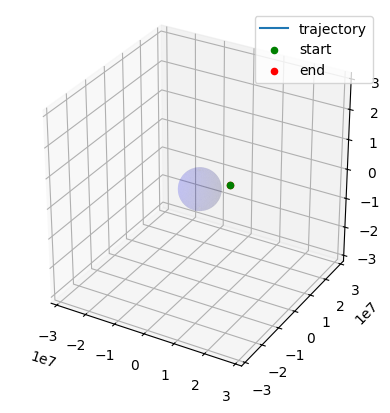

In [31]:
## ODE integration
N_STEPS = 10000
t = np.linspace(TIME_RANGE[0], TIME_RANGE[1], N_STEPS)
"""
result = spi.solve_ivp(y_prime, TIME_RANGE, Y0, atol=1e5)
if not result.success:
    print("Integration failed")
    print(result.message)
    exit(1)


t_int = result.t
y_int = result.y
if DEBUG:
    print(f"Got result: {y_int.shape}")
    print(y_int[:, 0])
    print(y_int[:, 1])
    print(f"Took {result.nfev} function evaluations")
"""

# # saving the results
# TODO

# """
# ODE integration
sol = spi.odeint(y_prime, Y0, t, tfirst=True, atol=1e4)
y_int = sol.T
print(f"Result has shape {y_int.shape}")
# """

"""
# ODE integration
y_int = spi.ode(y_prime) \
    .set_integrator('dopri5') \
    .set_initial_value(Y0, t[0])

t1 = 25
dt = 1

while y_int.successful() and y_int.t < t1:
    print(y_int.t+dt, y_int.integrate(y_int.t+dt))
print("Done")

y_int = y_int.y
"""

plot_trajectory(y_int[:3, :], y_int[3:, :], t, show_earth=True)

In [32]:
## Backward integration
# linearized equations of motion - backward
def y_prime_back(t, y):
    # to be compatible with the scipy integrator, we need the following signature
    x = y[:3]
    v = -y[3:]
    a = (gamma_inv(v) / M) * force(x, v)
    ydot = np.concatenate((v, a))
    if DEBUG:
        print(f"1/gamma = {gamma_inv(v)}")
        print(f"a = {a}")
        print(f"ydot: {ydot}")
    return np.concatenate((v, a))



In [34]:

X_0 = [7e6, 7e6, 0]
V_0 = [-5e6, -1e6, 1e6]
Y0 = np.concatenate((X_0, V_0))

sol = spi.odeint(y_prime_back, Y0, t, tfirst=True, atol=1e4)
y_int = sol.T
print(f"Result has shape {y_int.shape}")

KeyboardInterrupt: 

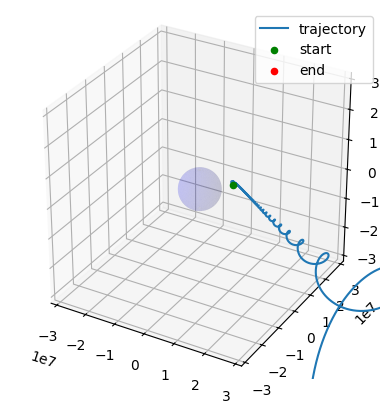

In [35]:
plot_trajectory(y_int[:3, :], y_int[3:, :], t, show_earth=True, fix_limits=True)
# CAUTION: start is the start of the backward integration -> so end was technically earlier


### Appendix - coordinate systems
The IGRF is usually computed in *geodetic* coordinates: the Earth is an ellipse and the coordinate axis follow the ellipsoid. 

To simplify the computation, we will use *geocentric* coordinates where we consider the Earth as a sphere.

In the following we will express vectors in the following 3D coordinate system:
- the origin is the center of the Earth
- r is given in km
- theta is given in degrees (corresponds to colatitudes) -> -90 to 90
- phi is given in degrees (corresponds to longitudes) -> -180 to 180


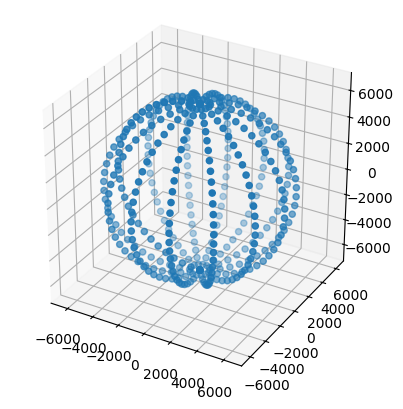

In [24]:
## Example - the spherical earth
# generate a grid of points that correspond to the surface of the earth
n = 15
lat_range = np.linspace(-90, 90, 2*n)
lon_range = np.linspace(-180, 180, n)
lat, lon = np.meshgrid(lat_range, lon_range)
lat = lat.flatten()
lon = lon.flatten()

# map to cartesian coordinates for plotting
r = 6.4e3
x = r * np.cos(np.radians(lat)) * np.cos(np.radians(lon))
y = r * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
z = r * np.sin(np.radians(lat))

# plot the grid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.scatter(x, y, z)
plt.show()